In [6]:
import numpy as np 
import tensorflow.keras.utils as ku 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O sonnets.txt
data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

--2021-05-18 11:38:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.223.208, 216.58.223.240, 2c0f:fb50:4003:801::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.223.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>]  91.38K   103KB/s    in 0.9s    

2021-05-18 11:38:54 (103 KB/s) - ‘sonnets.txt’ saved [93578/93578]



In [6]:
model = Sequential()
model.add(Embedding(total_words, 1000, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words*2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 1000)          3211000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 10, 300)           1381200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_6 (Dense)              (None, 6422)              1290822   
_________________________________________________________________
dense_7 (Dense)              (None, 3211)              20624253  
Total params: 26,828,075
Trainable params: 26,828,075
Non-trainable params: 0
__________________________________________

In [7]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 93s 180ms/step - loss: 7.3575 - accuracy: 0.0186
Epoch 2/100
484/484 [==============================] - 89s 185ms/step - loss: 6.4772 - accuracy: 0.0220
Epoch 3/100
484/484 [==============================] - 99s 205ms/step - loss: 6.3068 - accuracy: 0.0283
Epoch 4/100
484/484 [==============================] - 87s 181ms/step - loss: 6.1873 - accuracy: 0.0343
Epoch 5/100
484/484 [==============================] - 84s 173ms/step - loss: 6.0882 - accuracy: 0.0395
Epoch 6/100
484/484 [==============================] - 87s 181ms/step - loss: 5.9539 - accuracy: 0.0468
Epoch 7/100
484/484 [==============================] - 87s 181ms/step - loss: 5.8614 - accuracy: 0.0495
Epoch 8/100
484/484 [==============================] - 86s 177ms/step - loss: 5.7469 - accuracy: 0.0594
Epoch 9/100
484/484 [==============================] - 86s 178ms/step - loss: 5.6141 - accuracy: 0.0670
Epoch 10/100
484/484 [==============================] - 88s 182m

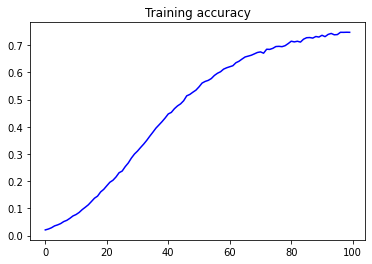

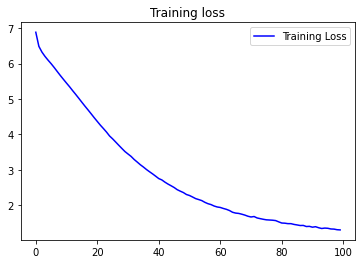

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)